In [1]:
import sys
sys.path.insert(0,'..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from model import Conformer as con
from data_processing import ukr_lang_chars_handle
from data_processing import CommonVoiceUkr
from model.conformer import Conformer as con

from config import *

In [2]:
tgt_n = 152
target = torch.randn(BATCH_SIZE, tgt_n) # (N, S) where N =batch size and S = max target length 

outputs = torch.randn(BATCH_SIZE, 1, 256, 38) # Tensor of size (T, N, C), where T = input length, N = batch size, and C = number of classes (including blank)
b, cnls, t, clss = outputs.shape
outputs = outputs.view(t*cnls, b, clss)


input_lengths = torch.full(size=(BATCH_SIZE,), fill_value=outputs.shape[0], dtype=torch.long)
target_lengths = torch.full(size=(BATCH_SIZE,), fill_value=target.shape[-1], dtype=torch.long)
print(input_lengths.shape)
print("input lengths:", input_lengths)

print(target_lengths.shape)
print("target lengths:", target_lengths)

ctc_loss = nn.CTCLoss(zero_infinity=False, reduction="none")
loss = ctc_loss(outputs, target, input_lengths, target_lengths)

torch.Size([4])
input lengths: tensor([256, 256, 256, 256])
torch.Size([4])
target lengths: tensor([152, 152, 152, 152])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from model import Conformer as con
from data_processing import ukr_lang_chars_handle
from data_processing import CommonVoiceUkr
from config import *
from torch.optim import RAdam
from tqdm import tqdm
import pprint
import numpy as np

# Making dataset and loader
ds = CommonVoiceUkr(TRAIN_PATH, TRAIN_SPEC_PATH)
train_dataloader = DataLoader(ds, shuffle=True, batch_size=BATCH_SIZE)

# Get model result
tgt_n = 152
src = torch.rand(BATCH_SIZE, 1, 256, 1024)
tgt = torch.rand(1, 1, 38, 152)
model = con()
result = model(src, tgt)
for param in model.parameters():
    if param.requires_grad == False:
        print(param)

# Create optimizator
optimizer = RAdam(model.parameters())

# Create CTC criterion
b, cnls, t, clss = result.shape
result = result.view(t * cnls, b, clss)
target = torch.randn(BATCH_SIZE, tgt_n)
input_lengths = torch.full(size=(BATCH_SIZE,), fill_value=result.shape[0], dtype=torch.long)
target_lengths = torch.full(size=(BATCH_SIZE,), fill_value=tgt.shape[-1], dtype=torch.long)
criterion = nn.CTCLoss(zero_infinity=True)
loss = criterion(result, target, input_lengths, target_lengths)

DEBUG_MSGS = False
running_loss = []
epoch = 0
for idx, (X, tgt) in tqdm(enumerate(train_dataloader)):
    optimizer.zero_grad()

    one_hots = ukr_lang_chars_handle.sentences_to_one_hots(tgt, 152)
    b, l, d = one_hots.shape
    one_hots = one_hots.view(b, 1, d, l)
    output = model(X, one_hots) # (batch, _, time, n_class)
    b, cnls, t, clss = output.shape
    output = output.view(t * cnls, b, clss) # (time, batch, n_class)
    output = F.log_softmax(output, dim=2)

    indeces = ukr_lang_chars_handle.sentences_to_indeces(tgt, 152)
    loss = criterion(output, indeces, input_lengths, target_lengths)
    #loss = torch.nan_to_num(output, posinf = 10, nan = 10)
    loss.backward()
    optimizer.step()

    running_loss.append(loss)

    #print("Loss:", loss)
    if torch.isnan(loss) or torch.isinf(loss):
        print("Target label:", tgt)
        print("Running loss:")
        pprint.pprint(running_loss)
        print(output.shape)
        print("Is nan in output:", torch.sum(torch.isnan(output)))
        print("Is inf in output:", torch.sum(torch.isinf(output)))
        pprint.pprint(output)
        break
    if (idx + 1) % 50 == 0:  # print every 200 mini-batches  
        running_loss = [t.detach().numpy() if type(t) is torch.Tensor else t for t in running_loss]
        running_loss = np.array(running_loss)
        zeros = np.sum(running_loss == 0)
        print(f"Loss mean: {np.mean(running_loss)}")
        print(f"Zeros percent { round(zeros / len(running_loss) * 100, 4)}%")
        wthout_zeros = running_loss[running_loss != 0]
        print(f"Loss mean without zeros: {np.mean(wthout_zeros)}")
        running_loss = list(running_loss)

50it [01:08,  1.37s/it]

Loss mean: 2.644441604614258
Zeros percent 10.0%
Loss mean without zeros: 2.9382684230804443


100it [02:14,  1.33s/it]

Loss mean: 2.339306592941284
Zeros percent 7.0%
Loss mean without zeros: 2.515383243560791


150it [03:19,  1.38s/it]

Loss mean: 2.035550117492676
Zeros percent 8.0%
Loss mean without zeros: 2.212554454803467


200it [04:25,  1.40s/it]

Loss mean: 1.9386273622512817
Zeros percent 8.0%
Loss mean without zeros: 2.107203722000122


250it [05:47,  1.67s/it]

Loss mean: 1.8685221672058105
Zeros percent 8.8%
Loss mean without zeros: 2.0488181114196777


300it [07:05,  1.58s/it]

Loss mean: 1.8232784271240234
Zeros percent 7.6667%
Loss mean without zeros: 1.9746695756912231


350it [08:23,  1.61s/it]

Loss mean: 1.76491379737854
Zeros percent 7.1429%
Loss mean without zeros: 1.9006764888763428


400it [09:42,  1.56s/it]

Loss mean: 1.7318053245544434
Zeros percent 7.0%
Loss mean without zeros: 1.8621561527252197


450it [10:59,  1.57s/it]

Loss mean: 1.7042174339294434
Zeros percent 7.3333%
Loss mean without zeros: 1.8390835523605347


500it [12:17,  1.58s/it]

Loss mean: 1.6681159734725952
Zeros percent 8.0%
Loss mean without zeros: 1.8131693601608276


550it [13:32,  1.40s/it]

Loss mean: 1.656899094581604
Zeros percent 7.8182%
Loss mean without zeros: 1.7974250316619873


600it [14:36,  1.27s/it]

Loss mean: 1.6514431238174438
Zeros percent 7.8333%
Loss mean without zeros: 1.7918007373809814


650it [15:44,  1.27s/it]

Loss mean: 1.6434659957885742
Zeros percent 7.8462%
Loss mean without zeros: 1.7833938598632812


700it [16:56,  1.51s/it]

Loss mean: 1.639408826828003
Zeros percent 7.7143%
Loss mean without zeros: 1.776449203491211


750it [18:13,  1.49s/it]

Loss mean: 1.6241981983184814
Zeros percent 7.8667%
Loss mean without zeros: 1.7628779411315918


800it [19:31,  1.55s/it]

Loss mean: 1.6156359910964966
Zeros percent 8.125%
Loss mean without zeros: 1.7585153579711914


850it [20:48,  1.54s/it]

Loss mean: 1.6120736598968506
Zeros percent 8.2353%
Loss mean without zeros: 1.7567468881607056


900it [22:07,  1.55s/it]

Loss mean: 1.6086757183074951
Zeros percent 7.7778%
Loss mean without zeros: 1.744347095489502


950it [23:26,  1.54s/it]

Loss mean: 1.6063376665115356
Zeros percent 7.7895%
Loss mean without zeros: 1.7420326471328735


1000it [24:44,  1.56s/it]

Loss mean: 1.5958166122436523
Zeros percent 8.1%
Loss mean without zeros: 1.7364708185195923


1008it [24:58,  1.49s/it]


RuntimeError: input_lengths must be of size batch_size

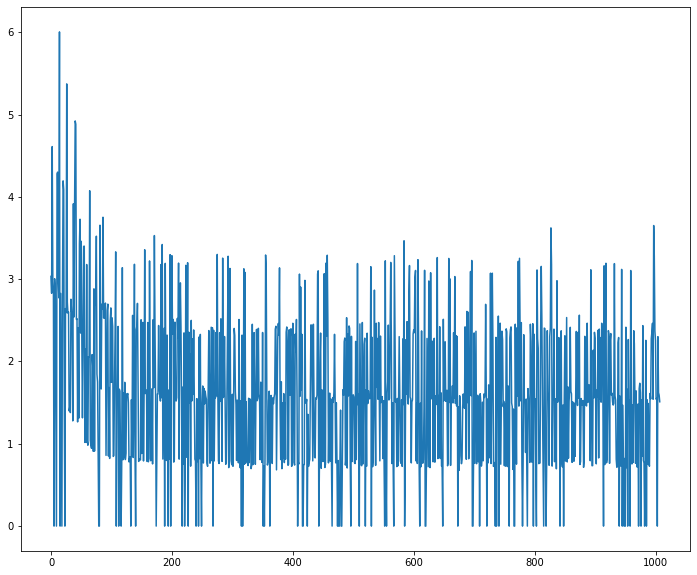

In [7]:
import matplotlib.pyplot as plt

losses_list = [t.detach().numpy() if type(t) is torch.Tensor else t for t in running_loss ]
plt.figure(figsize=(12, 10))
plt.plot(losses_list)
plt.show()

1008


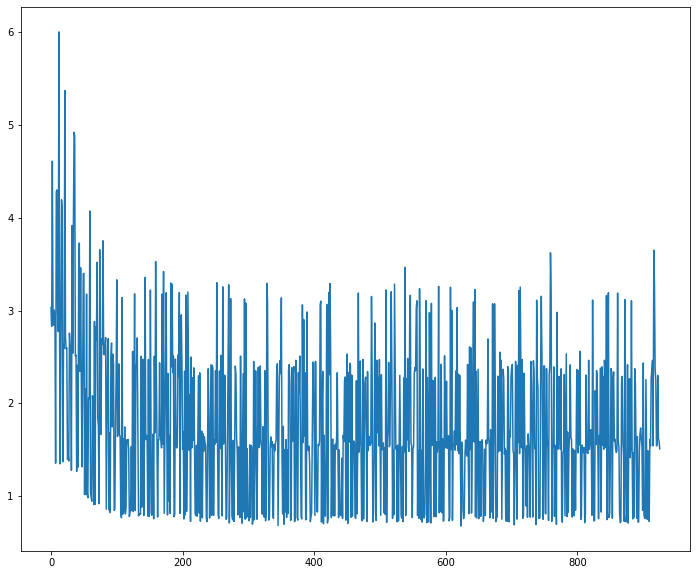

In [10]:
import matplotlib.pyplot as plt

wtout_zeros = np.array([t.detach().numpy() if type(t) is torch.Tensor else t for t in running_loss])
print(len(running_loss))
wtout_zeros = wtout_zeros[wtout_zeros != 0]
plt.figure(figsize=(12, 10))
plt.plot(wtout_zeros)
plt.show()

In [ ]:
t = torch.Tensor()
type(t) is torch.Tensor

In [ ]:
np.array([1, 2, 3, 4]) != 0

In [43]:
model.eval()
ds = CommonVoiceUkr(TRAIN_PATH, TRAIN_SPEC_PATH)
train_dataloader = DataLoader(ds, shuffle=True, batch_size=1)

with torch.no_grad():
    X, tgt = next(iter(train_dataloader))
    print(tgt)
    print(X.shape)
    tgt = ("",)
    one_hots = ukr_lang_chars_handle.sentences_to_one_hots(tgt, 152)
    b, l, d = one_hots.shape
    one_hots = one_hots.view(b, 1, d, l)
    
    out_data = model(X, one_hots)
    out_data = F.log_softmax(out_data, dim=-1)
    print(out_data.shape)
    b, c, h, w = out_data.shape
    out_data = out_data.view(h, w)
    result = ukr_lang_chars_handle.one_hots_to_sentence(out_data)
    print(f"result : '{result}'")

('Падіння виробництва і прибутків - вилучення грошей з обігу.',)
torch.Size([1, 1, 256, 1024])
torch.Size([1, 1, 256, 38])
result : '<sos><eos><sos><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos><eos><blank><blank><blank><blank><eos><eos><eos>